In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path 
%matplotlib inline

In [3]:
data_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/91APPdataset/'
order_data = pd.read_csv(data_path + 'Orders.csv')

/home/kevin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
order_data['new_DateId'] = pd.to_datetime(order_data['DateId'], format="%Y%m%d")
order_data['Year_Month'] = order_data['new_DateId'].dt.to_period('M').dt.to_timestamp()
order_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5495276 entries, 0 to 5495275
Data columns (total 30 columns):
DateId                         5495276 non-null int64
MemberId                       5495276 non-null int64
OrderGroupCode                 5495276 non-null object
TrackSourceTypeDef             5495276 non-null object
TrackDeviceTypeDef             5495276 non-null object
PayProfileTypeDef              5495276 non-null object
SalesOrderSlaveId              5495276 non-null int64
SalePageId                     5495276 non-null int64
IsMajor                        5495276 non-null bool
IsGift                         5495276 non-null bool
IsSalePageGift                 5495276 non-null bool
Quantity                       5495276 non-null int64
UnitPrice                      5495276 non-null float64
PromotionDiscount              5495276 non-null float64
ECouponId                      5495276 non-null int64
ECouponDiscount                5495276 non-null float64
SalesOrderSlaveT

In [5]:
print("Time Range")
print("First Record Time:", order_data['new_DateId'].min())
print("Last Record Time:", order_data['new_DateId'].max())

Time Range
First Record Time: 2015-05-06 00:00:00
Last Record Time: 2018-04-15 00:00:00


## 清理 City 資料
### 清理City 變數中亂碼和舊制行政區
* 先列出目前City內的所有值
* 將亂碼以'other'代替
* 將行政區更新為目前的行政區劃，留下直轄市、省轄市和縣

In [6]:
print(order_data['City'].unique())
city_name_list = [i for i in order_data['City'].unique() if str(i)>='\u4e00' and str(i)<='\u9fff']

['嘉義縣' '桃園市' '台南市' '新北市' '新竹市' '台北市' '苗栗縣' '台中市' '高雄市' '彰化縣' '屏東縣' '新竹縣'
 '宜蘭縣' '花蓮縣' '雲林縣' '台東縣' '基隆市' '南投縣' '嘉義市' '台東市' '澎湖縣' '屏東市' 'New' '<fo'
 'Kao' 'Kot' 'Tao' 'Hy ' nan '25 ' 'Keb' '1st' 'Tai' 'Ins' '桃園縣' 'Đại'
 'Cha' 'Xin' 'Quậ' 'Nan' 'No.' 'Hsi' 'Daf' 'Aya' 'Jia']


In [7]:
# 處理亂碼
correct_value_list = city_name_list + [np.nan]
order_data['City'] = order_data['City'].apply(lambda x: 'other' if x not in correct_value_list else x)

# 整理舊制行政區，留下直轄市、省轄市和縣
order_data['City'] = order_data['City'].apply(lambda x: '桃園市' if x == '桃園縣' else x)
order_data['City'] = order_data['City'].apply(lambda x: '屏東縣' if x == '屏東市' else x)
order_data['City'] = order_data['City'].apply(lambda x: '台東縣' if x == '台東市' else x)

In [8]:
order_data.groupby('City')['City'].count().sort_values(ascending=False)

City
新北市      1174232
台中市       799081
台北市       693837
桃園市       587026
高雄市       569046
台南市       398810
彰化縣       196922
新竹市       145389
新竹縣       127179
屏東縣       123144
苗栗縣       106055
基隆市        87806
雲林縣        86060
宜蘭縣        85122
南投縣        73099
花蓮縣        67688
嘉義縣        66482
嘉義市        53985
台東縣        34452
澎湖縣        19647
other        205
Name: City, dtype: int64

### 將縣市分成北部、中部、南部、東部、離島

In [9]:
dict_region = {"北部":['台北市','新北市','基隆市','宜蘭縣','桃園市','新竹縣', '新竹市'],
           "中部":['苗栗縣','台中市','彰化縣','南投縣','雲林縣'],
           "南部":['嘉義縣','嘉義市','台南市','高雄市','屏東縣'],
           "東部":['花蓮縣','台東縣'],
           "離島":['澎湖縣']
          }

def set_region(x, dict_region):
    for key, value in dict_region.items():
        if x in value:
            return key

order_data['Region'] = order_data['City'].apply(lambda x: set_region(x, dict_region))                                                

##  消費者購物行為
### 定義平均每月消費一次以上的客戶為91App平台的忠實消費者
* 取出成功消費的紀錄，然後將客戶的消費次數由大到小列出
* 資料集涵蓋時間範圍約為3年, 所以將消費次數除以36得到平均消費次數
* 將 Loyalty 變數設定為 1 如果(消費次數/36) > 1, 反之為0

In [10]:
customer_group = order_data[order_data.StatusDef == 'Finish'].groupby('MemberId')['SalesOrderReceiverId']
customer_shoptimes = customer_group.nunique().sort_values(ascending=False).reset_index(name='ShopTimes')
customer_shoptimes['Loyalty'] = customer_shoptimes['ShopTimes'].apply(lambda x: 1 if x/36 >= 1 else 0)
customer_shoptimes

,MemberId,ShopTimes,Loyalty
0,2028202,125,1
1,3765199,108,1
2,3287557,95,1
3,1218330,92,1
4,1390315,90,1
5,860645,87,1
6,2304912,82,1
7,620298,75,1
8,1107335,74,1
9,2308760,72,1


## 消費者分群與視覺化
### 以地區與消費者購買頻率劃分
* 地區：北部、中部、南部、東部、離島
* 消費者行為：忠實顧客（平均每月消費一次）、路人

### 合併地區與消費者行為資料

In [11]:
customer_segmentation = pd.merge(order_data[['MemberId', 'Region']].drop_duplicates(), customer_shoptimes[['MemberId', 'Loyalty']])
customer_segmentation

,MemberId,Region,Loyalty
0,1388133,南部,0
1,365787,北部,0
2,1388127,南部,0
3,1230537,北部,0
4,1388164,北部,0
5,1388138,北部,0
6,1370967,北部,0
7,1388120,南部,0
8,505220,北部,0
9,505220,中部,0


In [12]:
customer_seg_group = customer_segmentation.groupby(['Region', 'Loyalty'])['MemberId']

### 計算分類於每月份之消費總額並視覺化

In [13]:
north_loyal = order_data[order_data['MemberId'].isin(customer_seg_group.get_group(('北部',1)))].groupby('Year_Month')['SalesOrderSlaveTotalPayment'].sum()
north_nonloyal = order_data[order_data['MemberId'].isin(customer_seg_group.get_group(('北部',0)))].groupby('Year_Month')['SalesOrderSlaveTotalPayment'].sum()

center_loyal = order_data[order_data['MemberId'].isin(customer_seg_group.get_group(('中部',1)))].groupby('Year_Month')['SalesOrderSlaveTotalPayment'].sum()
center_nonloyal = order_data[order_data['MemberId'].isin(customer_seg_group.get_group(('中部',0)))].groupby('Year_Month')['SalesOrderSlaveTotalPayment'].sum()

south_loyal = order_data[order_data['MemberId'].isin(customer_seg_group.get_group(('南部',1)))].groupby('Year_Month')['SalesOrderSlaveTotalPayment'].sum()
south_nonloyal = order_data[order_data['MemberId'].isin(customer_seg_group.get_group(('南部',0)))].groupby('Year_Month')['SalesOrderSlaveTotalPayment'].sum()

east_loyal = order_data[order_data['MemberId'].isin(customer_seg_group.get_group(('東部',1)))].groupby('Year_Month')['SalesOrderSlaveTotalPayment'].sum()
east_nonloyal = order_data[order_data['MemberId'].isin(customer_seg_group.get_group(('東部',0)))].groupby('Year_Month')['SalesOrderSlaveTotalPayment'].sum()

outlying_island_loyal = order_data[order_data['MemberId'].isin(customer_seg_group.get_group(('離島',1)))].groupby('Year_Month')['SalesOrderSlaveTotalPayment'].sum()
outlying_island_nonloyal = order_data[order_data['MemberId'].isin(customer_seg_group.get_group(('離島',0)))].groupby('Year_Month')['SalesOrderSlaveTotalPayment'].sum()

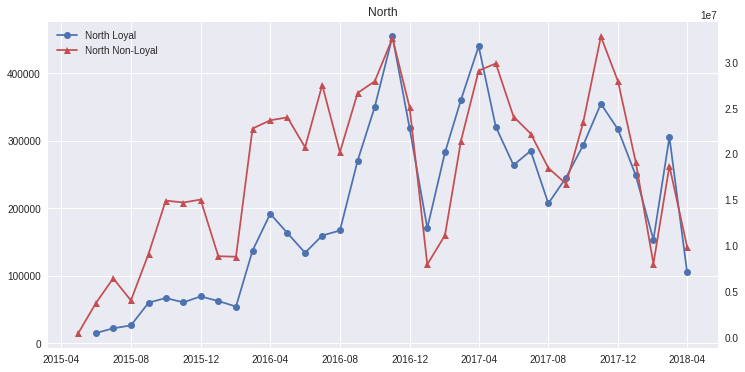

In [57]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 1, 1)
nr_l= ax1.plot(north_loyal, marker = 'o', color='C0', label = 'North Loyal')

ax2 = ax1.twinx() 
nr_nl = ax2.plot(north_nonloyal, marker = '^', color='C2', label = 'North Non-Loyal')

plt.title('North')
plt.legend(nr_l+nr_nl,['North Loyal','North Non-Loyal'], loc='upper left')
plt.grid(None)

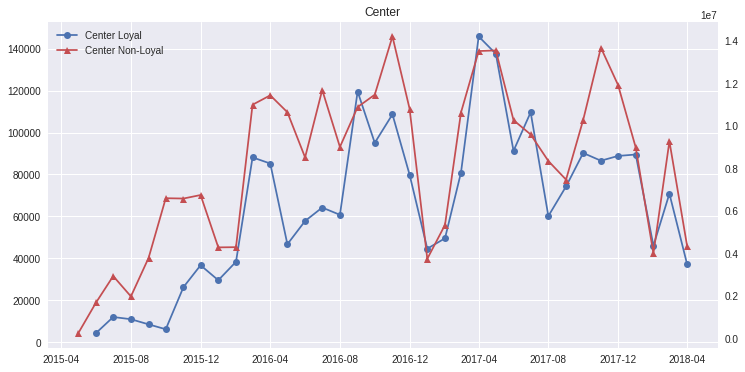

In [59]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 1, 1)
l= ax1.plot(center_loyal, marker = 'o', color='C0', label = 'Center Loyal')

ax2 = ax1.twinx() 
nl = ax2.plot(center_nonloyal, marker = '^', color='C2', label = 'Center Non-Loyal')

plt.title('Center')
plt.legend(l+nl,['Center Loyal','Center Non-Loyal'], loc='upper left')
plt.grid(None)

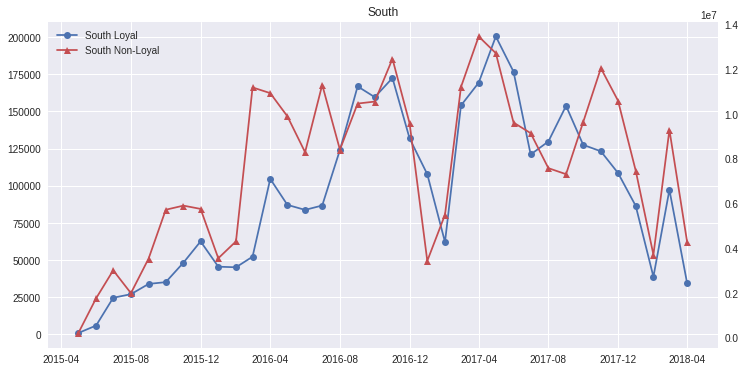

In [60]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 1, 1)
l= ax1.plot(south_loyal, marker = 'o', color='C0', label = 'South Loyal')

ax2 = ax1.twinx() 
nl = ax2.plot(south_nonloyal, marker = '^', color='C2', label = 'South Non-Loyal')

plt.title('South')
plt.legend(l+nl,['South Loyal','South Non-Loyal'], loc='upper left')
plt.grid(None)

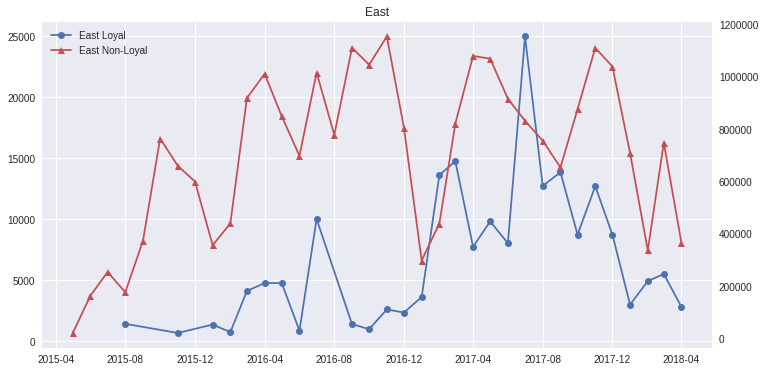

In [61]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 1, 1)
l= ax1.plot(east_loyal, marker = 'o', color='C0', label = 'East Loyal')

ax2 = ax1.twinx() 
nl = ax2.plot(east_nonloyal, marker = '^', color='C2', label = 'East Non-Loyal')

plt.title('East')
plt.legend(l+nl,['East Loyal','East Non-Loyal'], loc='upper left')
plt.grid(None)

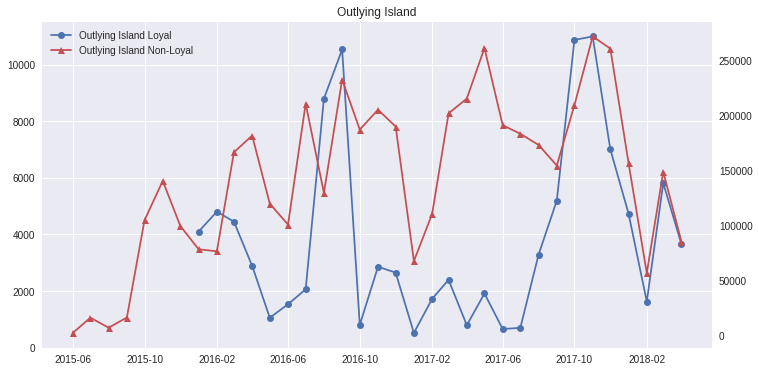

In [62]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 1, 1)
l= ax1.plot(outlying_island_loyal, marker = 'o', color='C0', label = 'Outlying Island Loyal')

ax2 = ax1.twinx() 
nl = ax2.plot(outlying_island_nonloyal, marker = '^', color='C2', label = 'Outlying Island Non-Loyal')

plt.title('Outlying Island')
plt.legend(l+nl,['Outlying Island Loyal','Outlying Island Non-Loyal'], loc='upper left')
plt.grid(None)